<a href="https://colab.research.google.com/github/Narayana0707/demppygit/blob/main/garbage%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

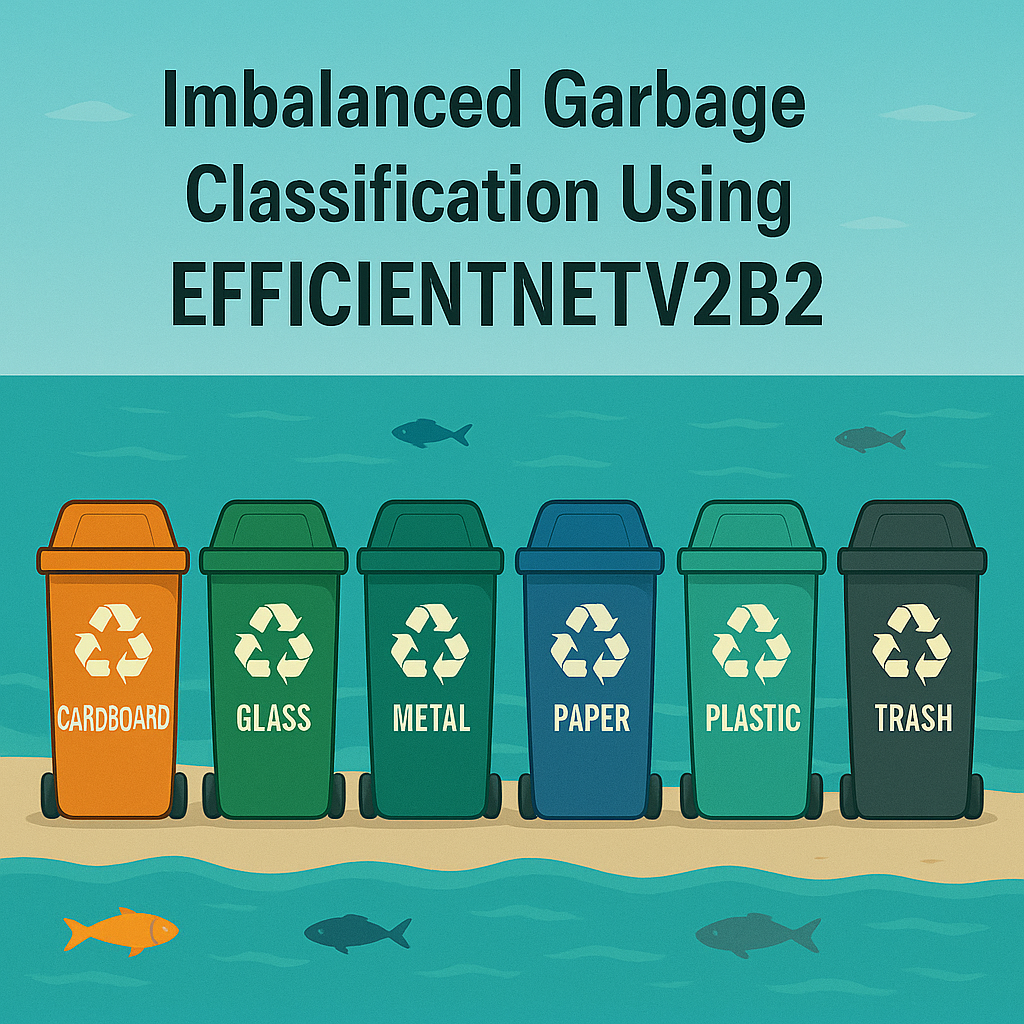

**Imbalanced Garbage Classification Using EfficientNetV2B2**

**Project Description**

In this project, we aim to develop a sophisticated garbage classification system leveraging the EfficientNetV2B2 architecture. Our primary dataset serves as a foundation for building models that can eventually automate waste segregation, a critical step in optimizing recycling and waste management, ultimately aiding in environmental conservation

**Goal:**

To develop an accurate and efficient garbage classification model using EfficientNetV2B2 and Transfer Learning, a machine learning technique where a pre-trained model developed for a specific task is reused as the starting point for a model on a different but related task.



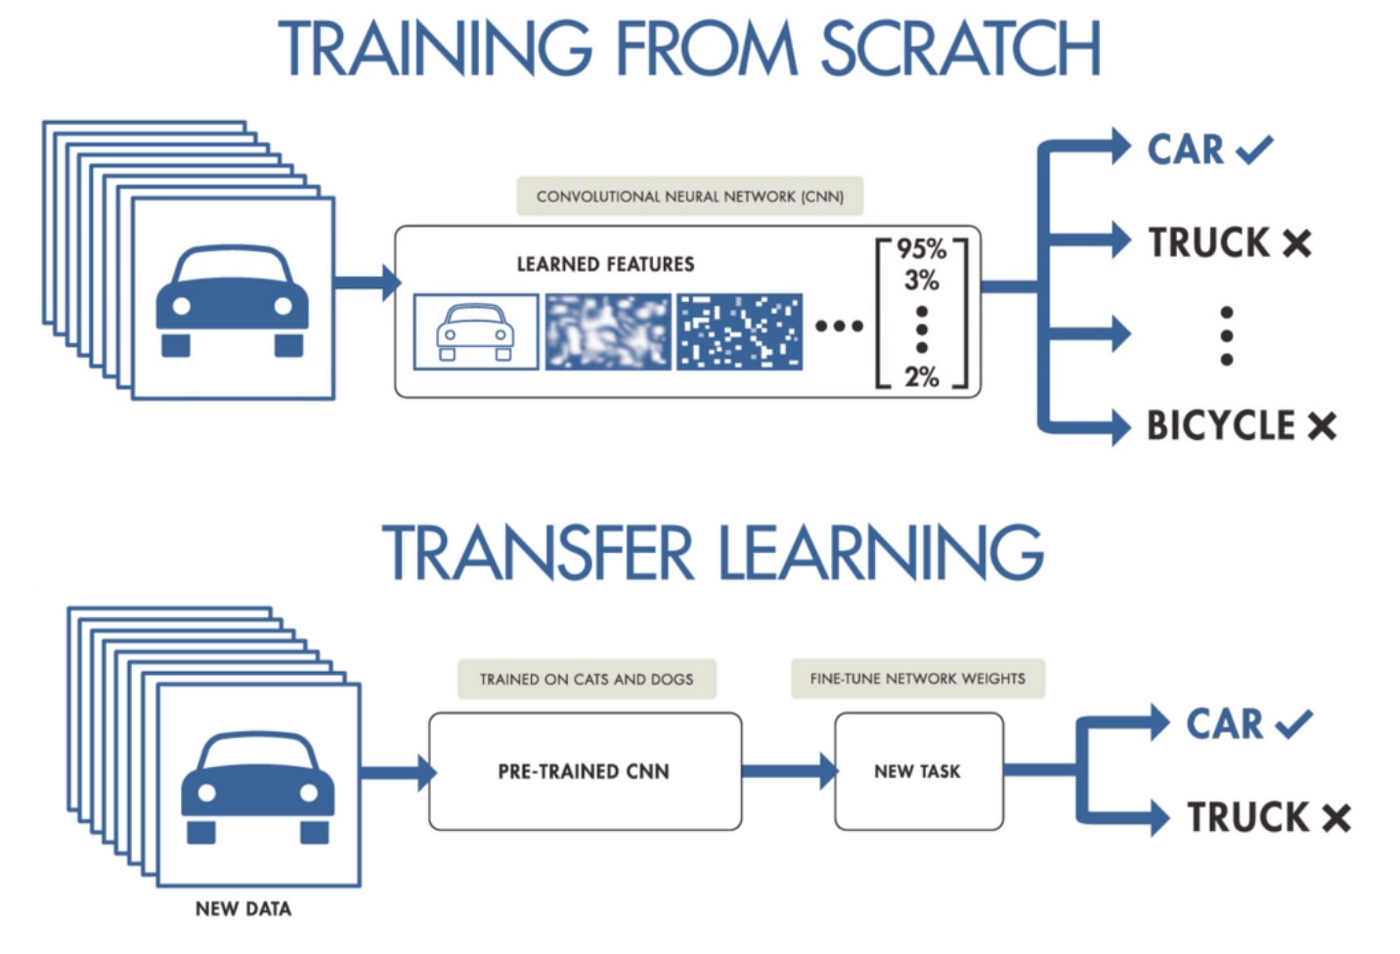

 **Benefits of Transfer Learning:**

1.Reduces training time — you don't start from scratch.

2.Leverages learned features from large datasets (like ImageNet).

3.Improves performance, especially with limited data.








**How Transfer Learning Works:**

1.Load a pretrained model (e.g., EfficientNetV2B2)

2.Freeze the base layers (optional)

3.Add custom classification layers

4.Train on the new dataset (fine-tune if needed)

**Why EfficientNetV2B2?**

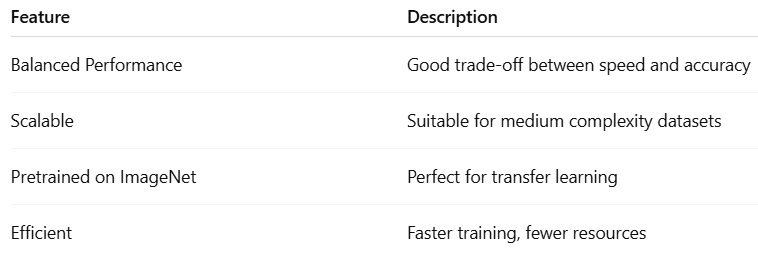

**Core Libraries:**

TensorFlow / Keras: Deep learning framework

NumPy: Numerical operations

Matplotlib, Seaborn: Visualization

Scikit-learn: Evaluation and class weights

Gradio: Interactive UI



In [4]:
import numpy as np  # Importing NumPy for numerical operations and array manipulations
import matplotlib.pyplot as plt  # Importing Matplotlib for plotting graphs and visualizations
import seaborn as sns  # Importing Seaborn for statistical data visualization, built on top of Matplotlib
import tensorflow as tf  # Importing TensorFlow for building and training machine learning models
from tensorflow import keras  # Importing Keras, a high-level API for TensorFlow, to simplify model building
from tensorflow.keras import Layer  # Importing Layer class for creating custom layers in Keras
from tensorflow.keras.models import Sequential  # Importing Sequential model for building neural networks layer-by-layer
from tensorflow.keras.layers import Rescaling , GlobalAveragePooling2D
from tensorflow.keras import layers, optimizers, callbacks  # Importing various modules for layers, optimizers, and callbacks in Keras
from sklearn.utils.class_weight import compute_class_weight  # Importing function to compute class weights for imbalanced datasets
from tensorflow.keras.applications import EfficientNetV2B2  # Importing EfficientNetV2S model for transfer learning
from sklearn.metrics import confusion_matrix, classification_report  # Importing functions to evaluate model performance
import gradio as gr  # Importing Gradio for creating interactive web interfaces for machine learning models


**1. Explore and Understand the Data**

1.Load image dataset using tools like image_dataset_from_directory.

2.Visualize sample images from each class.

3.Check the number of images per class to ensure balance.

4.Understand image dimensions, color channels, and class labels.

**Load image dataset using tools like image_dataset_from_directory.**

We are using a different dataset but keeping the same class labels (e.g., cardboard, glass, metal, paper, plastic, trash).

This ensures model consistency while testing on new image data for the same classification task.



**Split data into training, validation, and testing sets.**

tf.keras.utils.image_dataset_from_directory(...)
Used to load images from a directory where each subfolder represents a class.



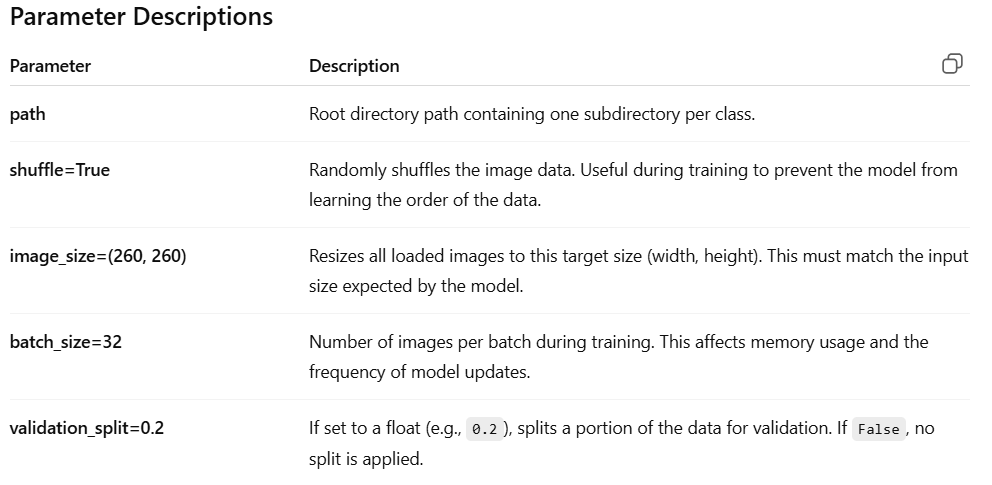

In [5]:
dataset_dir= r"C:\Users\Edunet Foundation\Downloads\project\garbage\TrashType_Image_Dataset"
image_size = (124, 124)
batch_size = 32
seed = 42

In [16]:
from google.colab import files
files.upload()
import zipfile

with zipfile.ZipFile("/content/garbage (2) (1).zip", 'r') as zip_ref:
    zip_ref.extractall("/content/TrashType_Image_Dataset")
dataset_dir = "/content/TrashType_Image_Dataset"
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    shuffle=True,
    image_size=(124, 124),
    batch_size=32
)





Saving garbage (2).zip to garbage (2) (3).zip
Found 18 files belonging to 1 classes.
Using 15 files for training.


In [17]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    shuffle = True,
    image_size=image_size,
    batch_size=batch_size
)
val_class= val_ds.class_names

Found 18 files belonging to 1 classes.
Using 3 files for validation.


In [18]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [20]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))


['garbage']
['garbage']
1


**Visualize sample images from each class.**

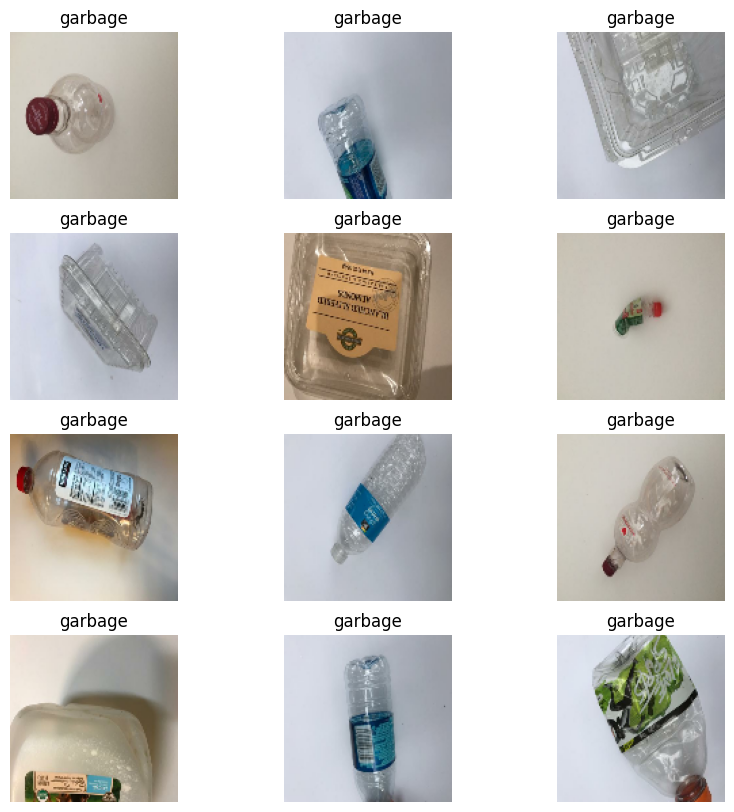

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

Check the number of images per class to ensure balance
Understand image properties like Image dimensions, Class labels

In [23]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to percentage

    return counts


In [24]:
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


In [28]:
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    if total == 0:
        return {k: 0.0 for k in class_names}  # Avoid division by zero

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)  # Convert to %

    return counts





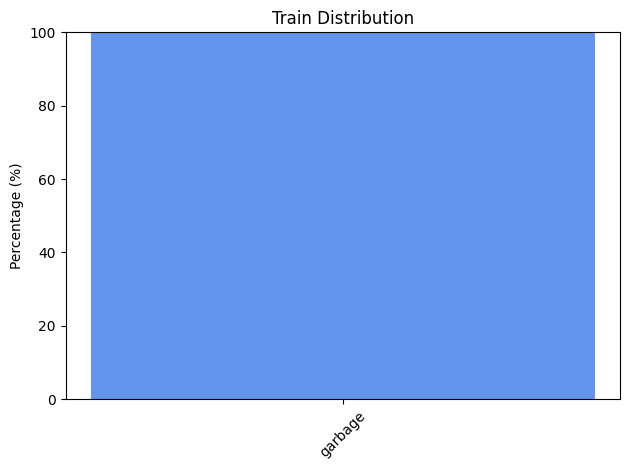

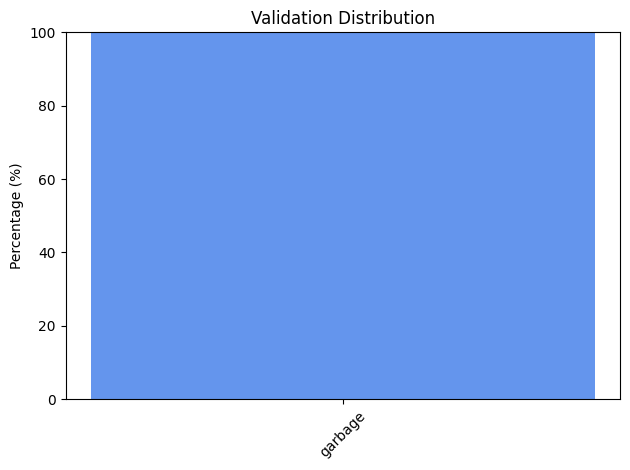

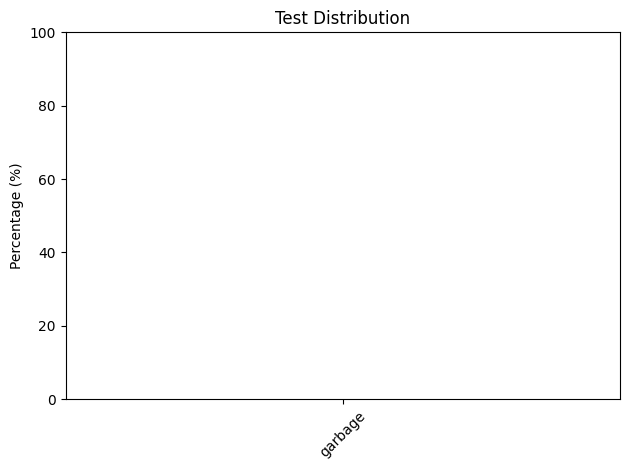

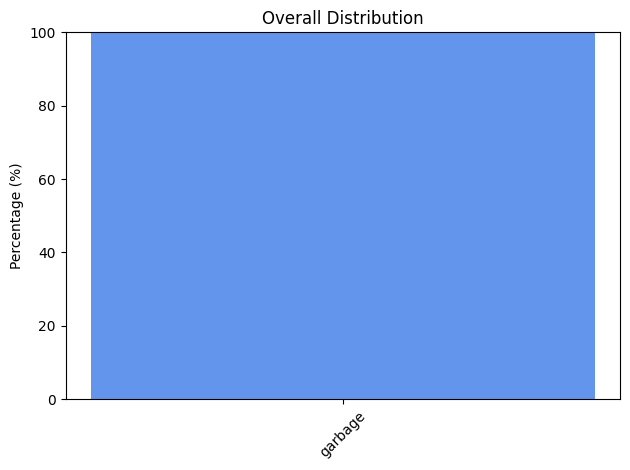

In [31]:
class_names = train_ds.class_names

train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)

# Handle test dataset safely
try:
    test_dist = count_distribution(test_ds, class_names)
except:
    print("⚠️ test_ds is empty or not defined. Setting test_dist to 0s.")
    test_dist = {k: 0.0 for k in class_names}

# Compute overall distribution
overall_dist = {}
for k in class_names:
    overall_dist[k] = round((train_dist.get(k, 0) + val_dist.get(k, 0)) / 2, 2)

# Plot
simple_bar_plot(train_dist, "Train Distribution")
simple_bar_plot(val_dist, "Validation Distribution")
simple_bar_plot(test_dist, "Test Distribution")
simple_bar_plot(overall_dist, "Overall Distribution")

